# 🔹 Sabriya Sowers' Spotify Tracks Analysis 🔹

**Author:** Sabriya Sowers  
**Date:** October 27, 2025  
**Objective:** Determine which musical and genre features most influence Spotify track popularity and use them to predict future track performance.

In [1]:
# ruff: noqa: F401
# pyright: reportUnusedImport=false

#data manipulation and analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# statistical data visualization
import seaborn

# sample housing dataset for regression analysis
from sklearn.datasets import fetch_california_housing

# building a linear regression model
from sklearn.linear_model import LinearRegression

# model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for splitting data into training and test sets
from sklearn.model_selection import train_test_split

In [2]:
# Load your CSV
df = pd.read_csv("spotifydataset.csv")  # same folder as the notebook
df.head()
y = df["popularity"].dropna()

print(df.keys())
print()

df.drop(
    axis="columns",
    labels=[
        "record_id", "track_id", "artists", "album_name", "track_name",
        "duration_ms", "explicit", "key", "loudness", "mode",
        "speechiness", "instrumentalness", "liveness", "time_signature"
    ],
    inplace=True
)

df.dropna(axis="index", how="any", inplace=True)

df.head(n=10)
df.info()
df.tail(n=5)

Index(['record_id', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   popularity    114000 non-null  int64  
 1   danceability  114000 non-null  float64
 2   energy        114000 non-null  float64
 3   acousticness  114000 non-null  float64
 4   valence       114000 non-null  float64
 5   tempo         114000 non-null  float64
 6   track_genre   114000 non-null  object 
dtypes: float64(5), int64(1), object(1)
memory usage: 6.1+ MB


,popularity,danceability,energy,acousticness,valence,tempo,track_genre
113995,21,0.172,0.235,0.640,0.0339,125.995,world-music
113996,22,0.174,0.117,0.994,0.0350,85.239,world-music
113997,22,0.629,0.329,0.867,0.7430,132.378,world-music
113998,41,0.587,0.506,0.381,0.4130,135.960,world-music
113999,22,0.526,0.487,0.681,0.7080,79.198,world-music


## Dataset
The dataset contains 114,000 individual Spotify tracks with 7 features used in the analysis. All selected variables have complete data, meaning there are no missing values for these features.

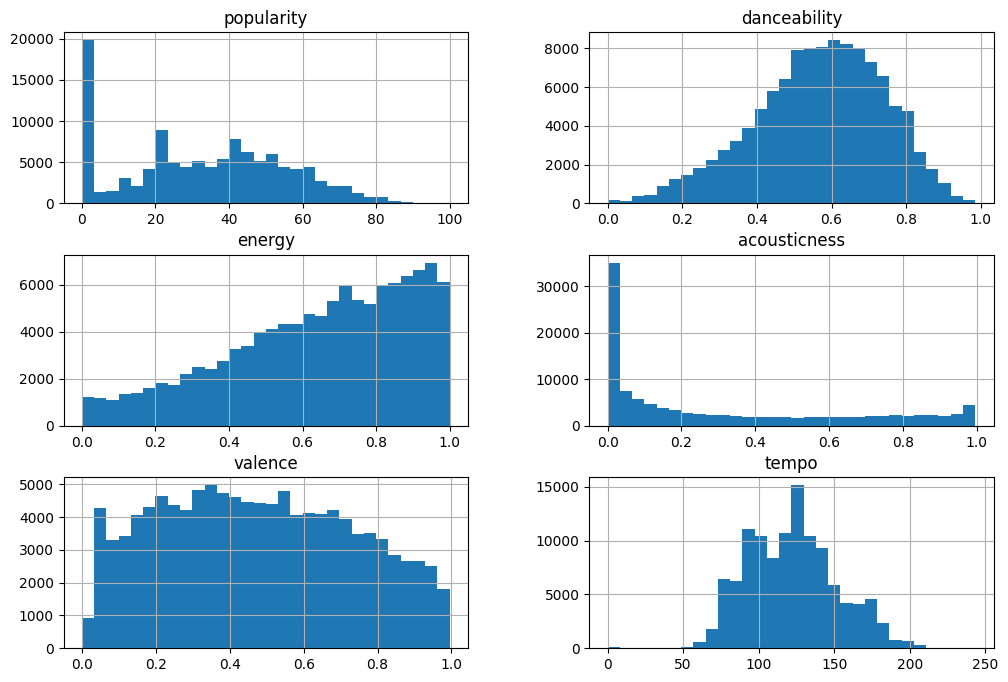

Text(0.5, 1.0, 'Distribution of Track Popularity')

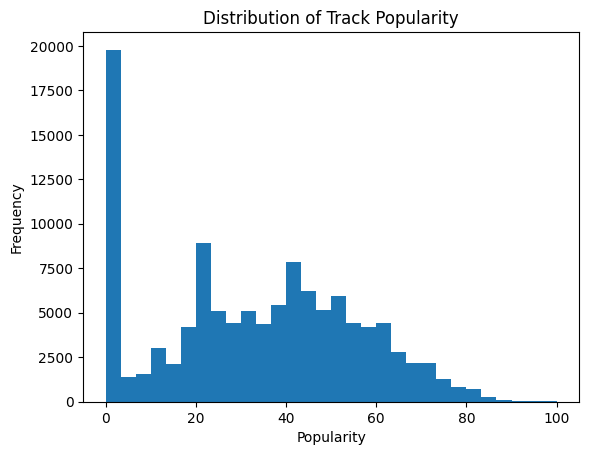

In [18]:
# Histogram with mean/median lines

# Calculates stats for your y target which is popularity
mean_val = y.mean()
median_val = y.median()
skew_val = y.skew()   # > 0 means right-skewed

# histogram for every numeric column in the entire DataFrame
df.hist(bins=30, figsize=(12, 8))

# Renders figure of many histograms
plt.show()

# single histogram specifically for popularity with labels
plt.hist(y, bins=30)
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.title("Distribution of Track Popularity")

In [ ]:
# This converts the numeric tempo values into 3 interpretable music categories that can be used in visualizations and predictive modeling.
df["tempo_group"] = pd.cut(
    df["tempo"],
    bins=[0, 90, 140, df["tempo"].max()],
    labels=["Slow","Medium","Fast"]
)

,tempo,tempo_group
0,87.917,Slow
1,77.489,Slow
2,76.332,Slow
3,181.740,Fast
4,119.949,Medium


Counts per group:
tempo_group
Medium    68289
Fast      29309
Slow      16402
Name: count, dtype: int64

Percent per group:
tempo_group
Medium    59.9%
Fast      25.7%
Slow      14.4%
Name: proportion, dtype: object


,count,mean,median,min,max
tempo_group,,,,,
Slow,16402,32.47,33.0,0,95
Medium,68289,33.10,34.0,0,100
Fast,29309,33.99,36.0,0,95


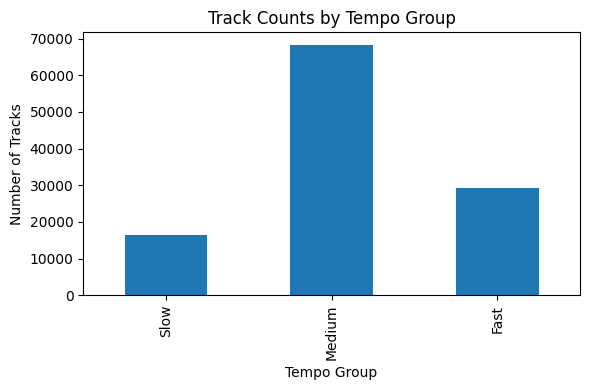

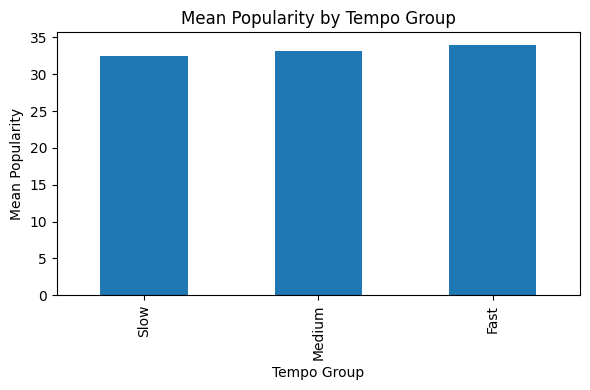

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Create the tempo groups (re-run safely; overwrites if exists)
df["tempo_group"] = pd.cut(
    df["tempo"],
    bins=[0, 90, 140, df["tempo"].max()],
    labels=["Slow","Medium","Fast"],
    include_lowest=True
)
# Keep an ordered categorical for nice sorting
df["tempo_group"] = pd.Categorical(df["tempo_group"], categories=["Slow","Medium","Fast"], ordered=True)

# 2) Quick peek of the new column
display(df[["tempo", "tempo_group"]].head())

# 3) Counts per group (absolute + %)
print("Counts per group:")
print(df["tempo_group"].value_counts(dropna=False))
print("\nPercent per group:")
print((df["tempo_group"].value_counts(normalize=True) * 100).round(1).astype(str) + "%")

# 4) Popularity by tempo group (useful summary table)
group_stats = (
    df.groupby("tempo_group", observed=True)["popularity"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
display(group_stats)

# 5) Simple visuals — counts and mean popularity
plt.figure(figsize=(6,4))
df["tempo_group"].value_counts().sort_index().plot(kind="bar")
plt.title("Track Counts by Tempo Group")
plt.xlabel("Tempo Group")
plt.ylabel("Number of Tracks")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
group_stats["mean"].plot(kind="bar")
plt.title("Mean Popularity by Tempo Group")
plt.xlabel("Tempo Group")
plt.ylabel("Mean Popularity")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

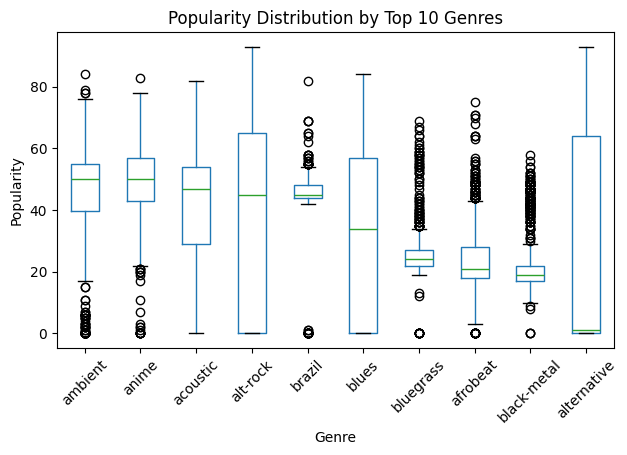

In [4]:
# Boxplot to display how popularity varies within each genre.
# Pick top 10 most common genres (keeps plot readable)
top_genres = df["track_genre"].value_counts().head(10).index
subset = df[df["track_genre"].isin(top_genres)].copy()

# Order genres by median popularity (high → low)
order = (subset.groupby("track_genre")["popularity"]
         .median()
         .sort_values(ascending=False)
         .index)
subset["track_genre"] = pd.Categorical(subset["track_genre"], categories=order, ordered=True)
subset = subset.sort_values("track_genre")

# Boxplot
plt.figure(figsize=(12,6))
subset.boxplot(column="popularity", by="track_genre", grid=False, rot=45)
plt.title("Popularity Distribution by Top 10 Genres")
plt.suptitle("")  # remove auto super-title
plt.xlabel("Genre")
plt.ylabel("Popularity")
plt.tight_layout()
# plt.savefig("boxplot_popularity_by_genre.png", dpi=150)  # optional for upload
plt.show()

## Feature Distribution Insights

✅ Popularity
- The popularity distribution is right-skewed
- Most tracks in the dataset have low popularity scores while fewer tracks achieve high popularity
- There is a large spike at the very low end (popularity close to 0), indicating many songs that are not widely streamed
- The long tail stretching toward higher popularity shows that only a small number of tracks become big hits.

✅ Danceability
- Bell-shaped distribution centered around ~0.6
- Most songs are moderately danceable

✅ Energy
- Distribution increases toward the right
- Many tracks have higher energy (e.g. loud, intense)

✅ Acousticness
- Inverse-U shape — lots of songs are either very acoustic or not acoustic at all
- Very few fall in the middle

✅ Valence
- Fairly even distribution
- Tracks span the full emotional range which can be from sad/dark to bright/cheerful

✅ Tempo
- Large cluster around 120–140 BPM (which is a typical pop tempo)
- Extreme slow/fast tempos are less common

✅ Genre
- Genres like Alternative, Acoustic, and Brazil show higher median popularity, meaning typical songs in those genres gain more listeners.
- Genres like Afrobeat, Bluegrass, and Black Metal have lower median popularity, meaning most of their tracks don’t become widely popular.
- Thee are some outliers which means Any genre can still produce very popular hit songs
- Popularity is uneven and not guaranteed by genre alone
- The overall spread shows that genre influences popularity, but it’s not the only factor and songs within the same genre can perform very differently.